# Algorithme MiniRocket

Ce Notebook permet d'exécuter l'algorithme **MiniRocket** pour résoudre le problème <font color = 'red'> **task1** </font>.

## Avant-propos

Dans cette section, on cherche à résoudre le problème intitulé <font color = 'red'> **task1** </font> c'est-à-dire à prédire la variable réponse `NB_DOSS_DAY` qui est le nombre de dossiers qui arrivent au backOffice par jour ou par semaine. 

Pour rappel, voici la table des données crédit avec la variable réponse : 

| Index | `DATEDI`   | `DELAI` | `TAINT`    |...|`NB_DOSS_DAY`|
|-------|------------|---------|----------  |---|-------------| 
|0	    |2017-10-19  |	 2	   | 2.4266	    |...|1            |
|1	    |2017-11-24	 |   0	   |1.6625	    |...|1            |
|2	    |2017-12-13  |  140	   |1.5104      |...|1            |
|3	    |2017-12-14  |	41     |	1.8146  |...|1            |
|4	    |2018-01-05  |	37     |	0.0000	|...|5            |
|...    |	...	     |...	   |...         |...|...          |
|42654  |2022-12-29  |	85     |	2.1305  |...|4            |
|42655  |2022-12-29  |	85     |	1.8658  |...|4            |
|42656  |2022-12-29  |	71     |	2.4777  |...|4            |
|42657  |2022-12-30  |	56     |	2.6312  |...|2            |
|42658  |2022-12-30  |	56     |	2.2938  |...|2            |

On voit que plusieurs crédits peuvent être édités pour la même date. Or, pour avoir une série temporelle (ST), il ne faut pas de doublons dans les dates. On va donc aggréger les données correspondant à une même date en prenant la classe majoritaire pour les variables qualitatives et la valeur moyenne pour les variables quantitatives.

Un autre problème est que les données temporelles ne sont pas continues dans le temps (nous n'avons pas une donnée tous les jours). Lorsque nous cherchons à faire de l'univarié c'est à dire à prédire `NB_DOSS_DAY` en fonction du temps seulement, nous pouvons ajouter des lignes aux journées manquantes et mettre pour ces lignes `NB_DOSS_DAY` = 0. Cependant, si nous voulons faire du multivarié, nous ne pouvons pas ajouter des lignes aux endroits où il manque des jours car il faudrait alors ajouter des valeurs pour toutes les autres variables ce qui n'est pas possible car ces valeurs sont inconnues. On peut peut-être aggréger les données par semaine (mais  de la même façon, il faut trouver des règles pour aggréger les données à la semaine et des règles pour trouver des valeurs pour les semaines où nous n'avons pas de crédits).

In [1]:
# Importation des packages nécessaires
# ---------------------------------------
# Importation des librairies python
import pandas as pd 
import numpy as np
import os

from ipywidgets import interact, fixed
import ipywidgets as widgets

# Importation des librairies du répertoire courant
from set_path import PATH,PATH_DATA,PATH_UTILS,PATH_PLOTS

# Importation des librairies du répertoire utilities
os.chdir(PATH_UTILS) # on se place dans utilities
from set_global import *
import data_prep_general as dpg
import data_viz as dv
import data_prep_task1 as dp1 
import miniRocket as mr
import denoising as dn
from denoising import arg_dash

print(">>> Pour savoir utiliser la fonction 'fct' de package 'lib' exécuter : help(lib.fct)")

os              : Windows-10-10.0.19041-SP0
python          : 3.7.2
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.28
sktime          : 0.16.0
sklearn         : 1.0.2
torch           : 1.13.1+cpu
device          : cpu
cpu cores       : 4
threads per cpu : 2
RAM             : 15.81 GB
GPU memory      : N/A
None


>>> Pour savoir utiliser la fonction 'fct' de package 'lib' exécuter : help(lib.fct)


In [2]:
# Affichage des variables sélectionnées dans le Notebook run_data_viz.ipynb pour la task1
# ---------------------------------------
print("Affichage des variables sélectionnées pour la task1")
print("VAR_REP_1 :", VAR_REP_1)
print("VAR_DATE_CREDIT_1 :", VAR_DATE_CREDIT_1)
print("VAR_QUANTI_CREDIT_1 :", VAR_QUANTI_CREDIT_1)
print("VAR_QUALI_CREDIT_1 :", VAR_QUALI_CREDIT_1)
print("VAR_QUANTI_CREDIT_1_f :", VAR_QUANTI_CREDIT_1_f)
print("VAR_QUANTI_CREDIT_1_i :", VAR_QUANTI_CREDIT_1_i)

Affichage des variables sélectionnées pour la task1
VAR_REP_1 : ['NB_DOSS_DAY']
VAR_DATE_CREDIT_1 : ['DATEDI']
VAR_QUANTI_CREDIT_1 : ['MEDOS', 'TAINT', 'TITEGI', 'QLDDOS', 'NBASSGPE', 'NBASSEXT', 'NBGAR', 'DELINS', 'DELDEC', 'DELEDI', 'CONSCE']
VAR_QUALI_CREDIT_1 : ['COPROG', 'COOBJ', 'TOPPSC', 'LIBLGG']
VAR_QUANTI_CREDIT_1_f : ['MEDOS', 'TAINT', 'TITEGI']
VAR_QUANTI_CREDIT_1_i : ['QLDDOS', 'NBASSGPE', 'NBASSEXT', 'NBGAR', 'DELINS', 'DELDEC', 'DELEDI', 'CONSCE']


## Data pre-processing

Data pre-processing nécessaire pour l'exécution de miniRocket

In [3]:
# Récupération des jeux de données
# ------------------------------------
#--- dataset CEMP
credits_CEMP = pd.read_csv(PATH_DATA + "/CEMP - Données CREDITS.csv", encoding='utf8', sep=';')
credits = credits_CEMP.copy()

# Pré-processing général de certaines variables (cas particuliers)
# ------------------------------------
credits = dpg.special_treatment(credits)

# Transformation des dates au format datetime
# -------------------------------------------
credits = dpg.type_date(credits,VAR_DATE_CREDIT)

# Interpolation des valeurs manquantes des variables dates
# -------------------------------------------
credits = dpg.interpolate_date(credits,VAR_DATE_CREDIT)

# Trier le dataframe par dates croissantes
# -------------------------------------------
credits = dpg.sort_by_date(credits)

# Ajout nombre de crédits par jour
# -----------------------------------------------
credits = dpg.compute_NB_DOSS_DAY(credits)

## Imputation des données

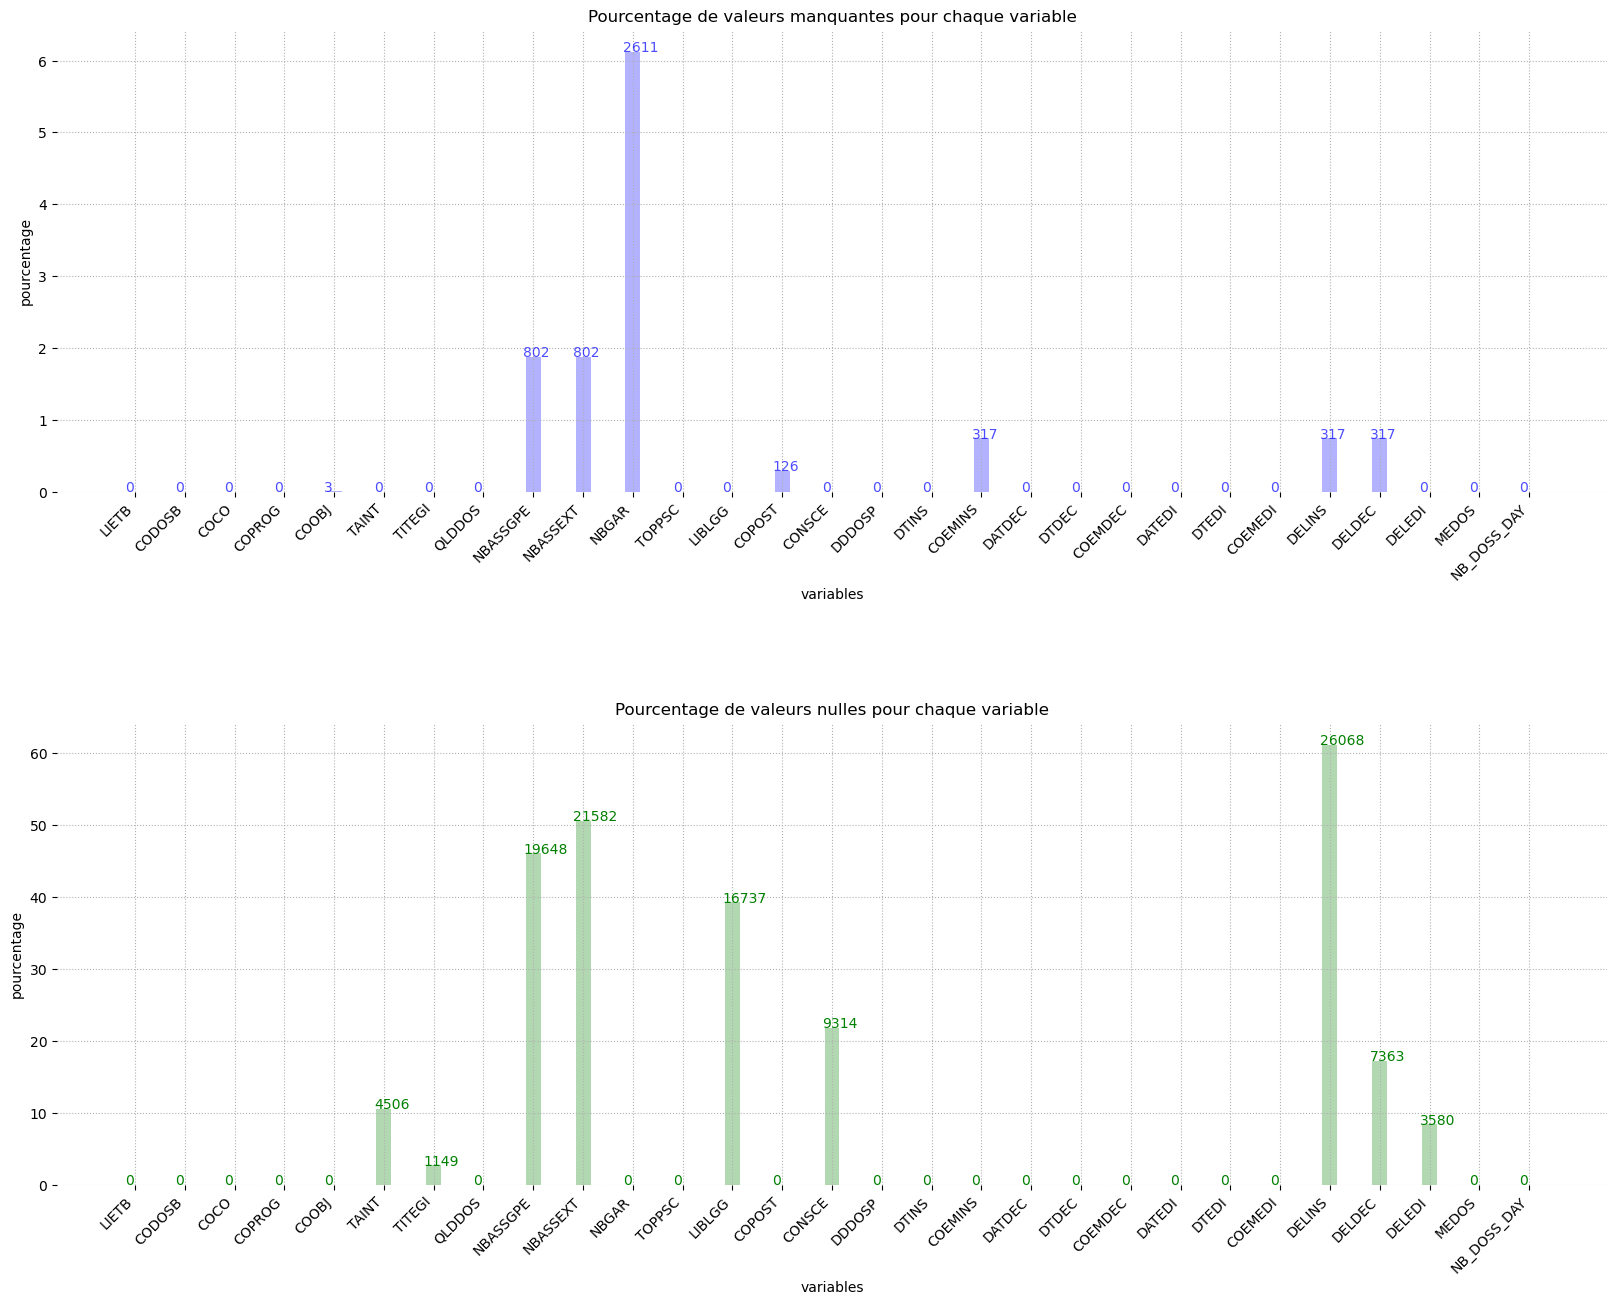

In [4]:
dv.plot_na_null(credits,credits.columns,fig_size=[20,15],plot_null=True)

**Observations:**

Parmi les variables que l'on va sélectionner, on observe des variables manquantes pour:
- `NBGAR` (Nbre de garanties) $\rightarrow$ on observe des valeurs manquantes pour `NBGAR` et aucune valeur nulle. On en déduit que lorsqu'un client n'a pas de garanties, la variable est manquante. On met donc toutes les variables manquantes de `NBGAR` à 0.
- `DELINS` (Nbre jours Instruction) $\rightarrow$ on sait que `DELINS` = `DTINS`(Date instruction traitée) - `DDD0SP`(Date instruction à traiter). Or nous avons déjà interpolé la variable `DTINS` et la variable `DDD0SP` n'est pas manquante. Nous pouvons donc calculer les valeurs manquantes de `DELINS`. 
- `DELDEC` (Nbre jrs Décision) $\rightarrow$ on sait que `DELDEC` = `DTDEC`(Date accord banque traitée) - `DATDEC`(Date accord banque à traiter). Or nous avons déjà interpolé la variable `DATDEC` et la variable `DTDEC` n'est pas manquante. Nous pouvons donc calculer les valeurs manquantes de `DELDEC`
- `NBASSGPE`(Nbre Assurance Groupe) et `NBASSEXT`(Nbre Assurance Externe)  $\rightarrow$  on observe le même nombre de valeurs manquantes pour ces 2 variables et après calcul on voit que les valeurs sont manquantes aux mêmes endroits pour ces deux variables. Or, un client est supposé posseder soit une assurance de groupe, soit une assurance externe. De plus, on voit que `NBASSGPE` et `NBASSEXT` ont environ le même nombre de 0. Pour un dossier dont l'assurance est manquante, on va donc tirer aléatoirement (avec proba 1/2) une assurance entre `NBASSGPE` et `NBASSEXT`, par exemple `NBASSGPE`. On met la valeur de `NBASSGPE` à 0 et on prend pour `NBASSEXT`, la moyenne. 
-  `COOBJ` (Code objet prêt) $\rightarrow$ possède très peu de valeurs manquantes. On impute par la modalité majoritaire.

In [5]:
# Imputation des données manquantes 
# -------------------------------------
credits = dp1.fill_na_1(credits)

## Sélection de variables 

In [6]:
# Selection des variables définies par l'analyse Exploratoire
# A EFFECTUER APRES fill_na_1
# -------------------------------------
credits1 = credits[VAR_DATE_CREDIT_1+VAR_QUANTI_CREDIT_1+VAR_QUALI_CREDIT_1+VAR_REP_1]

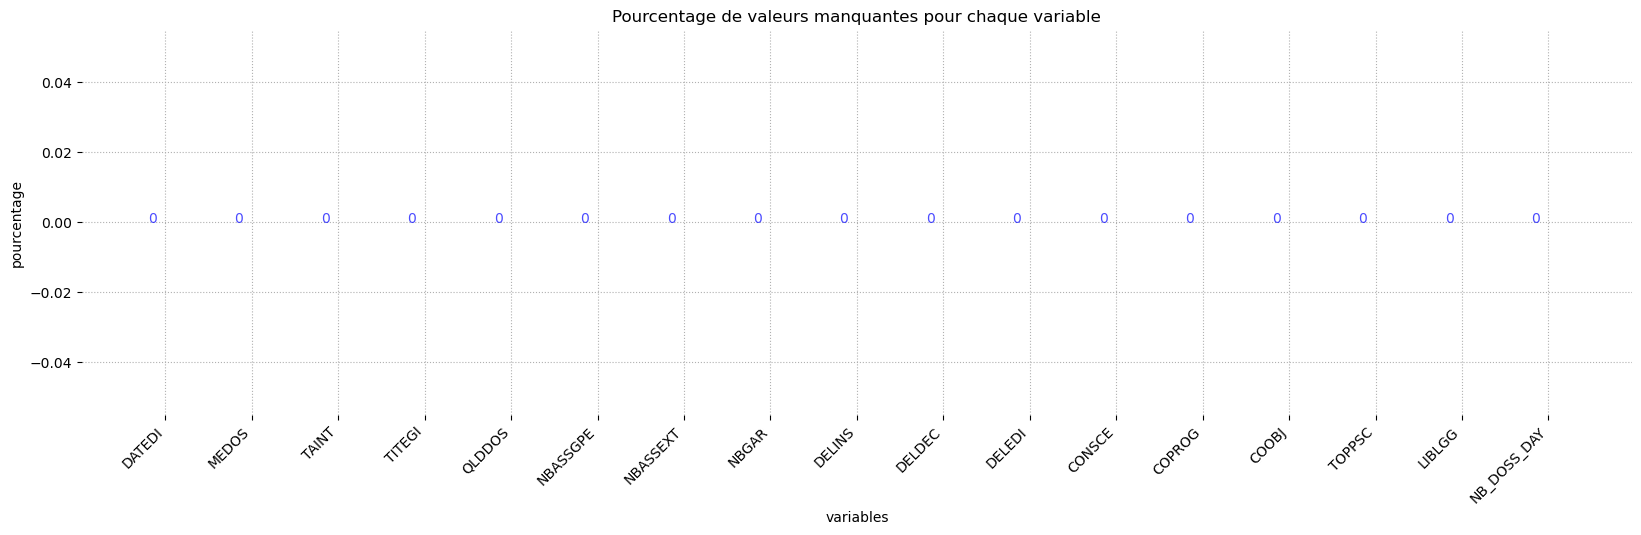

In [7]:
# Vérification qu'il ne reste plus de variables manquantes
# -------------------------------------
dv.plot_na_null(credits1,credits1.columns,fig_size=[20,5],plot_null=False)

## Cas Multivarié

### Création MTS

MTS : Multivariate Time Series = série temporelle multivariée.

Afin d'avoir le format d'une Série Temporelle, on aggrège les données correspondant à une même date en prenant la classe majoritaire pour les variables qualitatives et la valeur moyenne pour les variables quantitatives.

In [8]:
credits_MTS = dp1.create_MTS_day(credits1,
                                 var_floats = VAR_QUANTI_CREDIT_1_f,
                                 var_int = VAR_QUANTI_CREDIT_1_i,
                                 var_quali = VAR_QUALI_CREDIT_1,
                                 var_date = VAR_DATE_CREDIT_1,
                                 var_rep = VAR_REP_1)

# Transformation des variables qualitative en pd.Categorical
# -------------------------------------
credits_MTS = dpg.to_Categorical(credits_MTS,VAR_QUALI_CREDIT_1)
credits_MTS.dtypes

MEDOS                 float64
TAINT                 float64
TITEGI                float64
QLDDOS                  int32
NBASSGPE                int32
NBASSEXT                int32
NBGAR                   int32
DELINS                  int32
DELDEC                  int32
DELEDI                  int32
CONSCE                  int32
COPROG               category
COOBJ                category
TOPPSC               category
LIBLGG               category
NB_DOSS_DAY             int32
DATEDI         datetime64[ns]
dtype: object

### One-Hot encoding

Pour appliquer MiniRocket, on doit one-hot encoder les variables. 
Cependant, il n'est pas nécessaire de renormaliser les variables pour appliquer MiniRocket.

In [9]:
# One-hot Encoding des données
# -------------------------------------------
credits_MTS_oh = mr.one_hot_encode(df=credits_MTS,num_cols=VAR_QUANTI_CREDIT_1 + VAR_REP_1,cat_cols=VAR_QUALI_CREDIT_1)

###  Données regroupées par Jour

#### MiniRocket Signal Brut

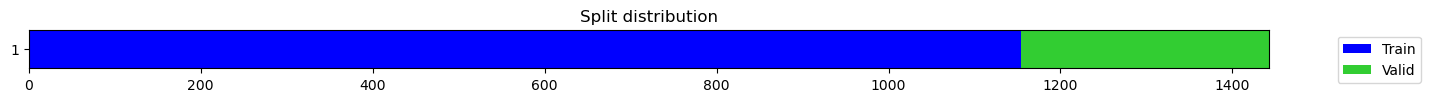

début de l'entraînement...
...fin !
rmse sur les données de test : 14.90991 temps d'exécution: 16.407569


In [10]:
# Entraînement MiniRocket
# -------------------------------------------
y_pred,rmse,splits = mr.run_miniRocket_multi(credits_MTS_oh,['NB_DOSS_DAY'],window_length=9,n_estimators=5,valid_size=.2)

Valeur moyenne de la ST originale:  29
Valeur moyenne de l'erreur:  12


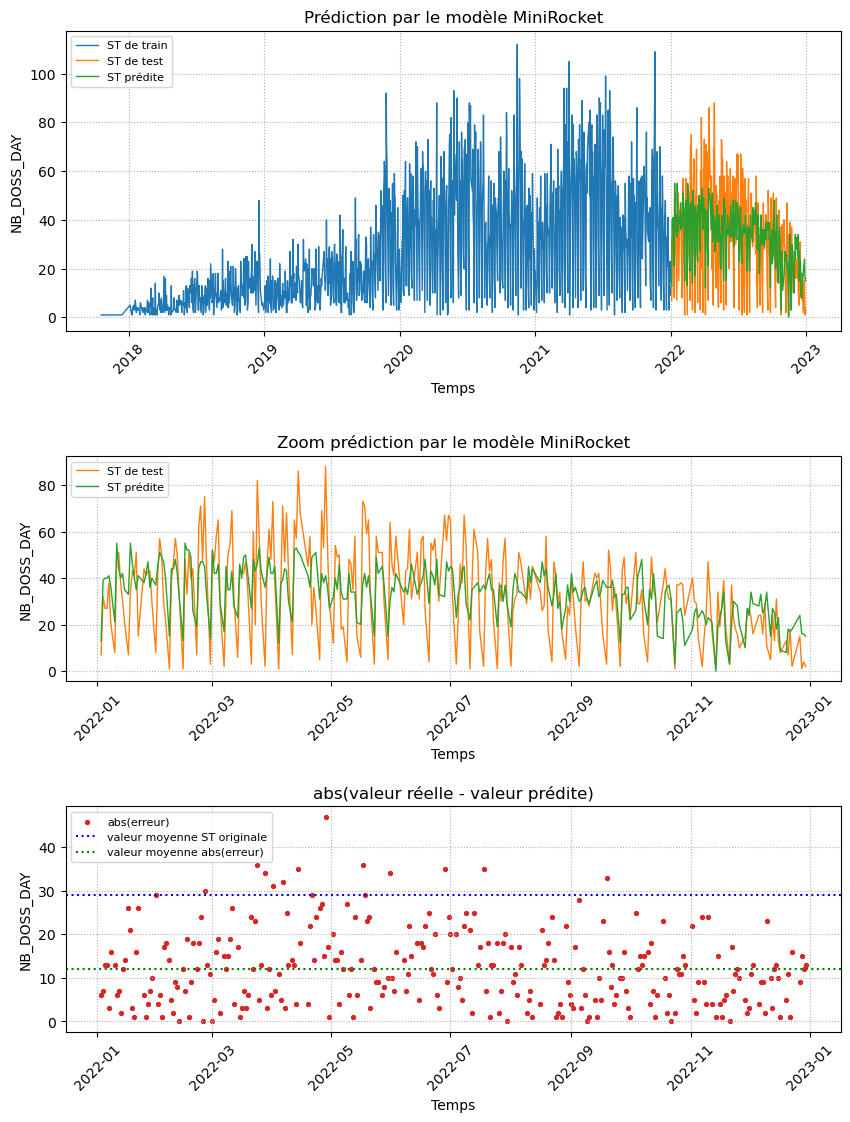

In [11]:
# Préparation de la Série temporelle pour affichage
# ----------------------------------------------
# ST avec en index une date et en valeur, la variable d'intérêt.
TS = credits_MTS['NB_DOSS_DAY'] 
TS.index = credits_MTS['DATEDI']
# ST prédite. Comme y_pred et TS[splits[1]] n'ont pas la même longueur à 
# cause des fenêtres glissantes, on effectue la manip ci-dessous
TS_forecast = TS*np.nan 
TS_forecast[-len(y_pred):] = y_pred

# Affichage de la Série temporelle
# ----------------------------------------------
dp1.plot_prediction(TS,TS_forecast,splits,conf_int=None,model_name='MiniRocket')

In [12]:
_ = dp1.compute_mae(TS[splits[1]],TS_forecast[splits[1]])

mae sur les données de test : 12.0625


## Cas Univarié

### Création TS

TS : Time Series = série temporelle univariée.

Afin d'avoir le format d'une Série Temporelle, on compte le nombre de crédits par jour (ou par semaine) et on met la valeur 0 si il n'y a pas de crédits. La série temporelle obtenue est continue dans le temps (les dates se suivent tous les jours ou toutes les semaines).

In [13]:
# Définition de séries temporelles univariées 
# ----------------------------------------------
# Données regroupées par jour
TS_day   = dp1.create_TS(credits,by='day')
# Données regroupées par buisiness day (jour sans le dimanche)
TS_day_B = dp1.create_TS(credits,by='business_day')
# Données regroupées par semaine
TS_week  = dp1.create_TS(credits,by='week')

### Débruitage

In [14]:
# Exploration des paramètres de  débruitage pour trouver les meilleurs paramètres 
# ----------------------------------------------
_ = interact(dn.plot_dash_debruitTrans, **arg_dash, 
             TS_week=fixed(TS_week), TS_day=fixed(TS_day))

interactive(children=(ToggleButtons(button_style='success', description='signal', options=('TS_week', 'TS_day'…

**Observations:**

Après réglage des paramètres, on retient les valeurs :

- pour TS_day: wave='sym19', seuil=0.5, translation=8 (on ne peut pas trop débruiter au risque de perdre beaucoup d'information.)

- pour TS_week: wave='sym11',seuil=1.5, translation=8

In [15]:
# Une fois que l'on a trouvé les bons paramètres avec le panel ci-dessus, on définit le signal débruité
# ----------------------------------------------
TSrec_day,_  = dn.DebruitTrans(TS_day,qmf='db3',T=.5,trans=8)
TSrec_week,_ = dn.DebruitTrans(TS_week,qmf='sym11',T=1.5,trans=8) #'db9'

### Données regroupées par jour

#### MiniRocket Signal Brut

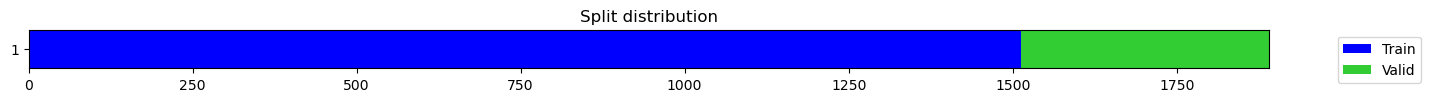

début de l'entraînement...
...fin !
rmse sur les données de test : 11.78264 temps d'exécution: 19.660234


In [16]:
# Entraînement signal brut
# ----------------------------------------------
y_pred,rmse,splits = mr.run_miniRocket_uni(TS_day,window_length=9,n_estimators=5,valid_size=.2)

Valeur moyenne de la ST originale:  22
Valeur moyenne de l'erreur:  7


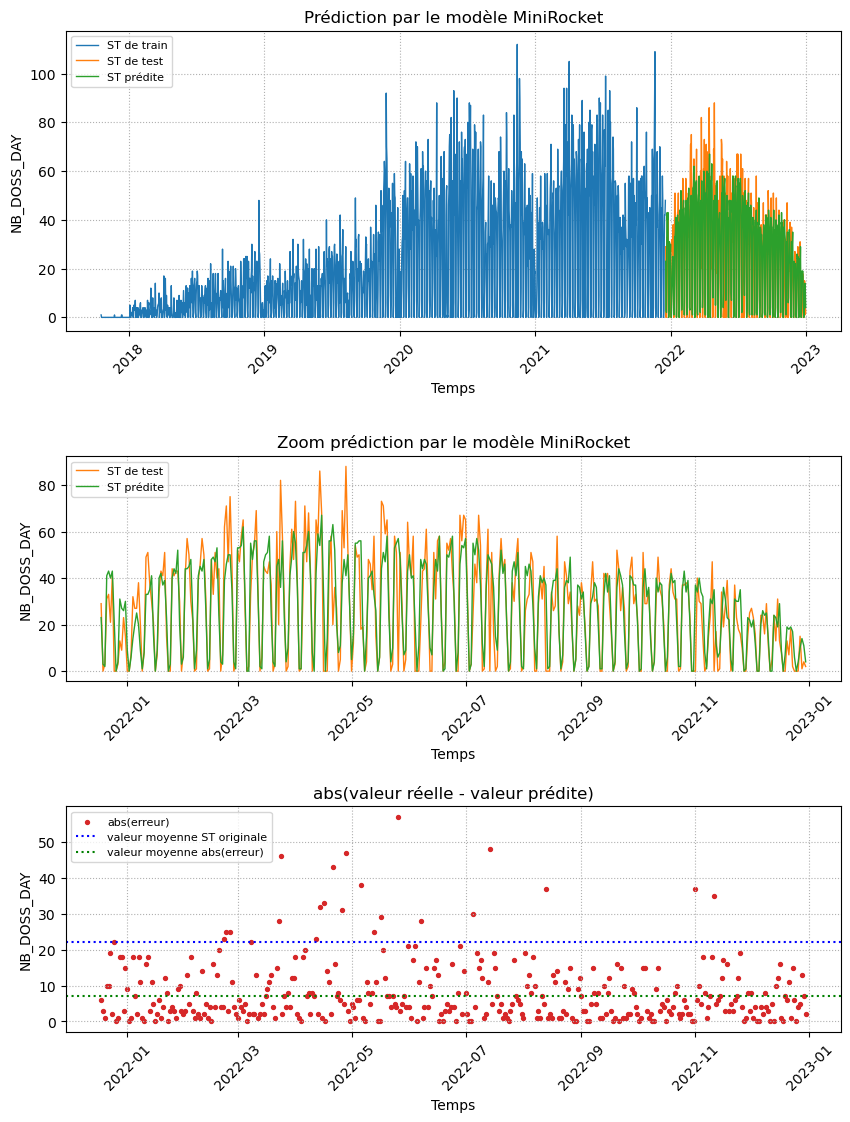

In [17]:
# Préparation de la Série temporelle pour affichage
# ----------------------------------------------
TS=TS_day.copy()
# ST prédite. Comme y_pred et TS[splits[1]] n'ont pas la même longueur à 
# cause des fenêtres glissantes, on effectue la manip ci-dessous
TS_forecast = TS*np.nan 
TS_forecast[-len(y_pred):] = y_pred

# Affichage de la Série temporelle
# ----------------------------------------------
dp1.plot_prediction(TS,TS_forecast,splits,conf_int=None,model_name='MiniRocket')

In [18]:
_ = dp1.compute_rmse(TS[splits[1]],TS_forecast[splits[1]])
_ = dp1.compute_mae(TS[splits[1]],TS_forecast[splits[1]])

rmse sur les données de test : 11.78264
mae sur les données de test : 7.90476


#### MiniRocket Signal Débruité

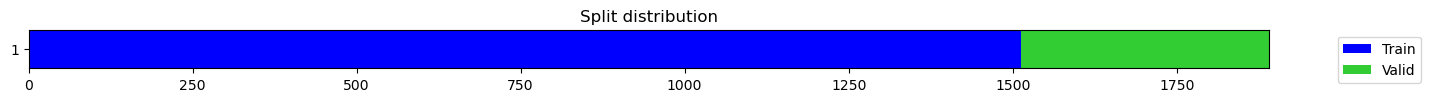

début de l'entraînement...
...fin !
rmse sur les données de test : 11.76184 temps d'exécution: 8.390889


In [19]:
# Entraînement signal débruité
# ----------------------------------------------
y_pred,rmse,splits = mr.run_miniRocket_uni(TSrec_day,window_length=9,n_estimators=5,valid_size=.2)

Valeur moyenne de la ST originale:  22
Valeur moyenne de l'erreur:  7


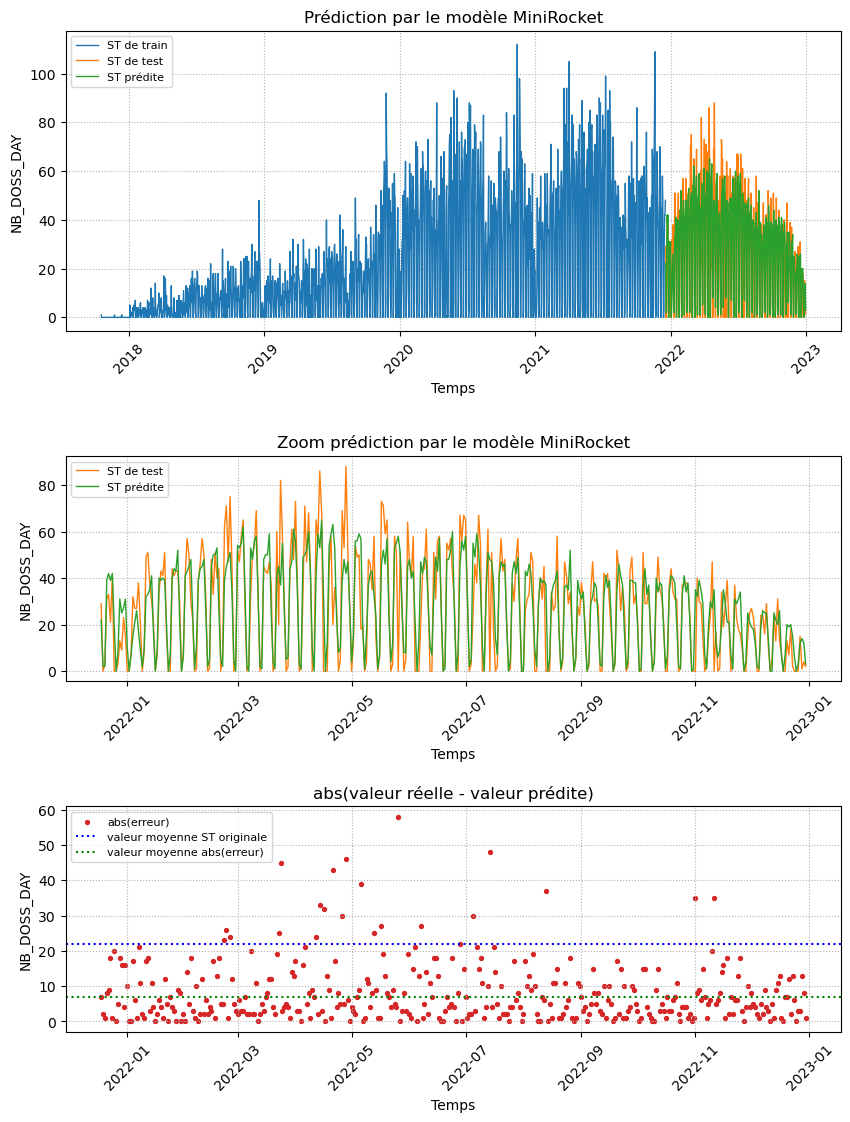

In [20]:
# Préparation de la Série temporelle pour affichage
# ----------------------------------------------
TS=TS_day.copy()
# ST prédite. Comme y_pred et TS[splits[1]] n'ont pas la même longueur à 
# cause des fenêtres glissantes, on effectue la manip ci-dessous
TS_forecast = TS*np.nan 
TS_forecast[-len(y_pred):] = y_pred

# Affichage de la Série temporelle
# ----------------------------------------------
dp1.plot_prediction(TS,TS_forecast,splits,conf_int=None,model_name='MiniRocket')

In [21]:
_ = dp1.compute_rmse(TS[splits[1]],TS_forecast[splits[1]])
_ = dp1.compute_mae(TS[splits[1]],TS_forecast[splits[1]])

rmse sur les données de test : 11.77523
mae sur les données de test : 7.96825


#### MiniRocket Signal Transformé Box-Cox

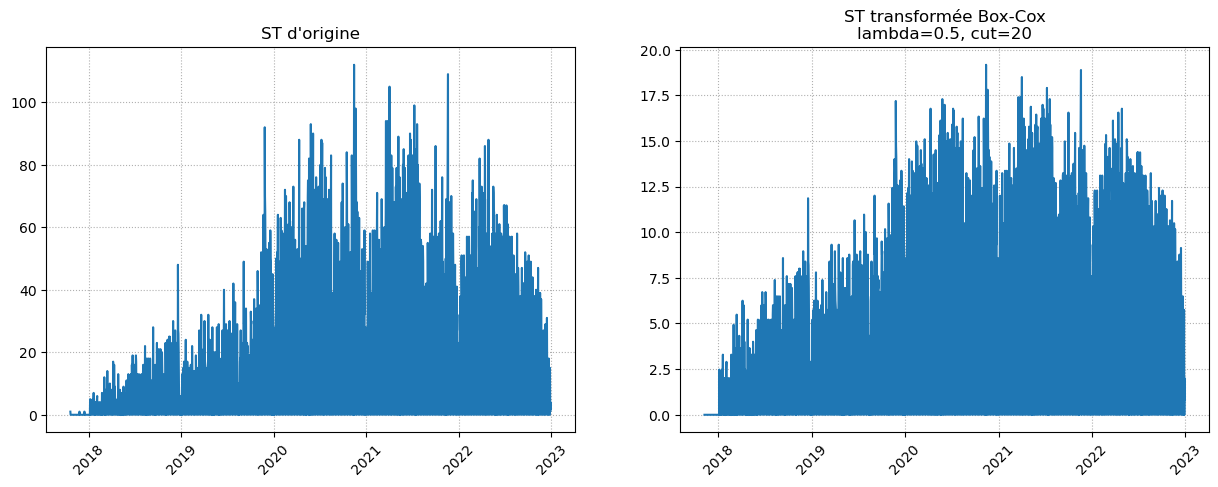

In [22]:
# Transformation du signal avec Box-Cox
# ----------------------------------------------
TS_trans,lam = dp1.transform_TS(TS_day,lam=.5)

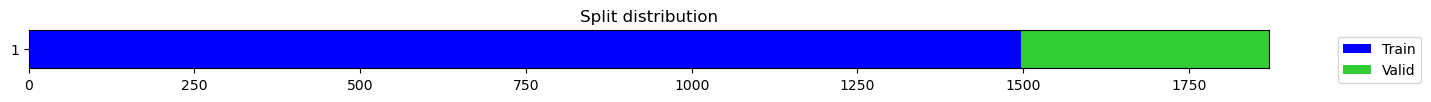

début de l'entraînement...
...fin !
rmse sur les données de test : 2.36339 temps d'exécution: 8.073105


In [23]:
# Entraînement signal transformé
# ----------------------------------------------
y_pred,rmse,splits = mr.run_miniRocket_uni(TS_trans,window_length=9,n_estimators=5,valid_size=.2)

Valeur moyenne de la ST originale:  22
Valeur moyenne de l'erreur:  8


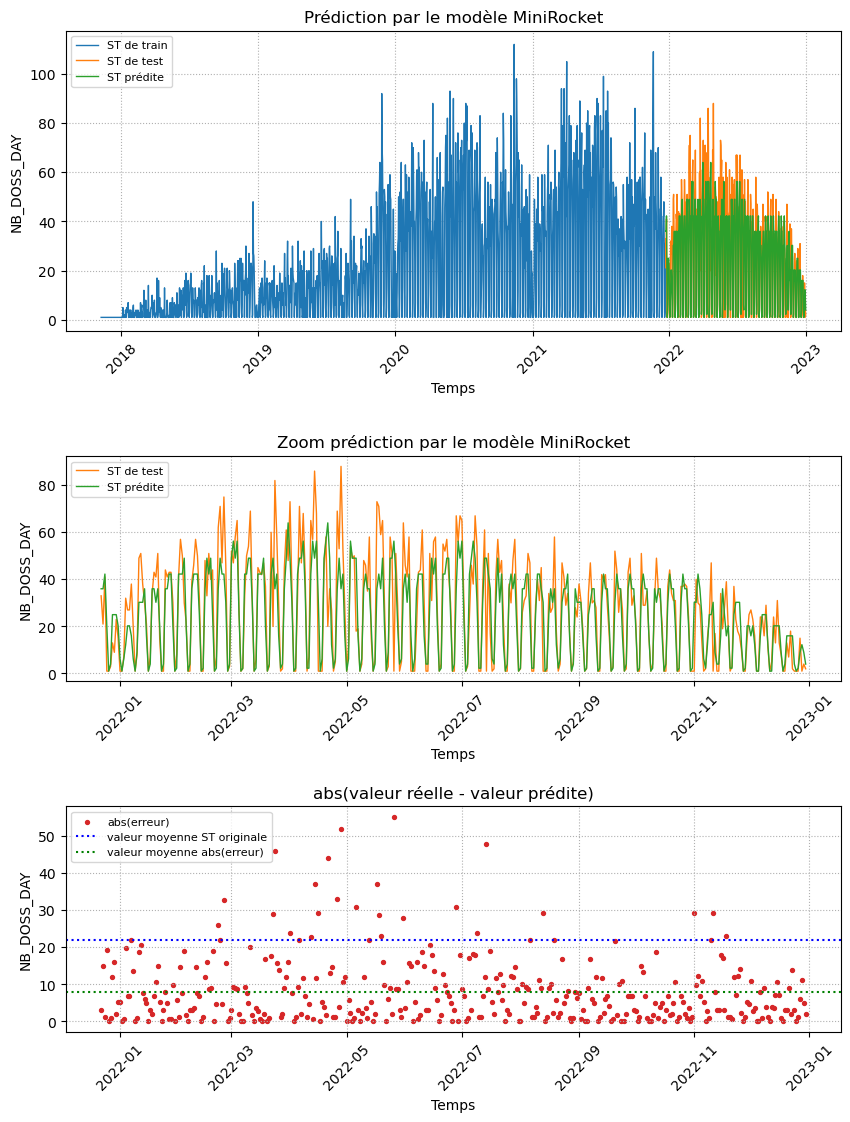

In [24]:
# Préparation de la Série temporelle pour affichage
# ----------------------------------------------
TS = TS_trans.copy()
TS =  dp1.transform_inv_TS(TS,lam)
# ST prédite. Comme y_pred et TS[splits[1]] n'ont pas la même longueur à 
# cause des fenêtres glissantes, on effectue la manip ci-dessous
TS_forecast = TS*np.nan 
TS_forecast[-len(y_pred):] = dp1.transform_inv_TS(y_pred,lam)

# Affichage de la Série temporelle
# ----------------------------------------------
dp1.plot_prediction(TS,TS_forecast,splits,conf_int=None,model_name='MiniRocket')

In [25]:
_ = dp1.compute_rmse(TS[splits[1]],TS_forecast[splits[1]])
_ = dp1.compute_mae(TS[splits[1]],TS_forecast[splits[1]])

rmse sur les données de test : 12.09516
mae sur les données de test : 8.05281


### Données regroupées par semaine

#### MiniRocket Signal Brut

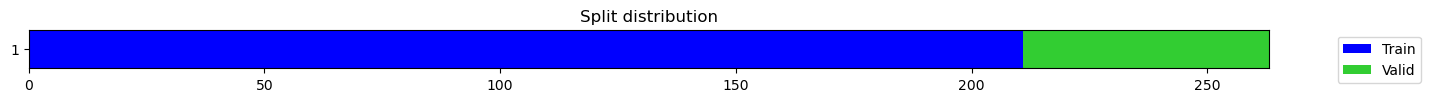

début de l'entraînement...
...fin !
rmse sur les données de test : 40.43799 temps d'exécution: 0.515567


In [26]:
# Entraînement signal brut
# ----------------------------------------------
y_pred,rmse,splits = mr.run_miniRocket_uni(TS_week,window_length=9,n_estimators=5,valid_size=.2)

Valeur moyenne de la ST originale:  156
Valeur moyenne de l'erreur:  30


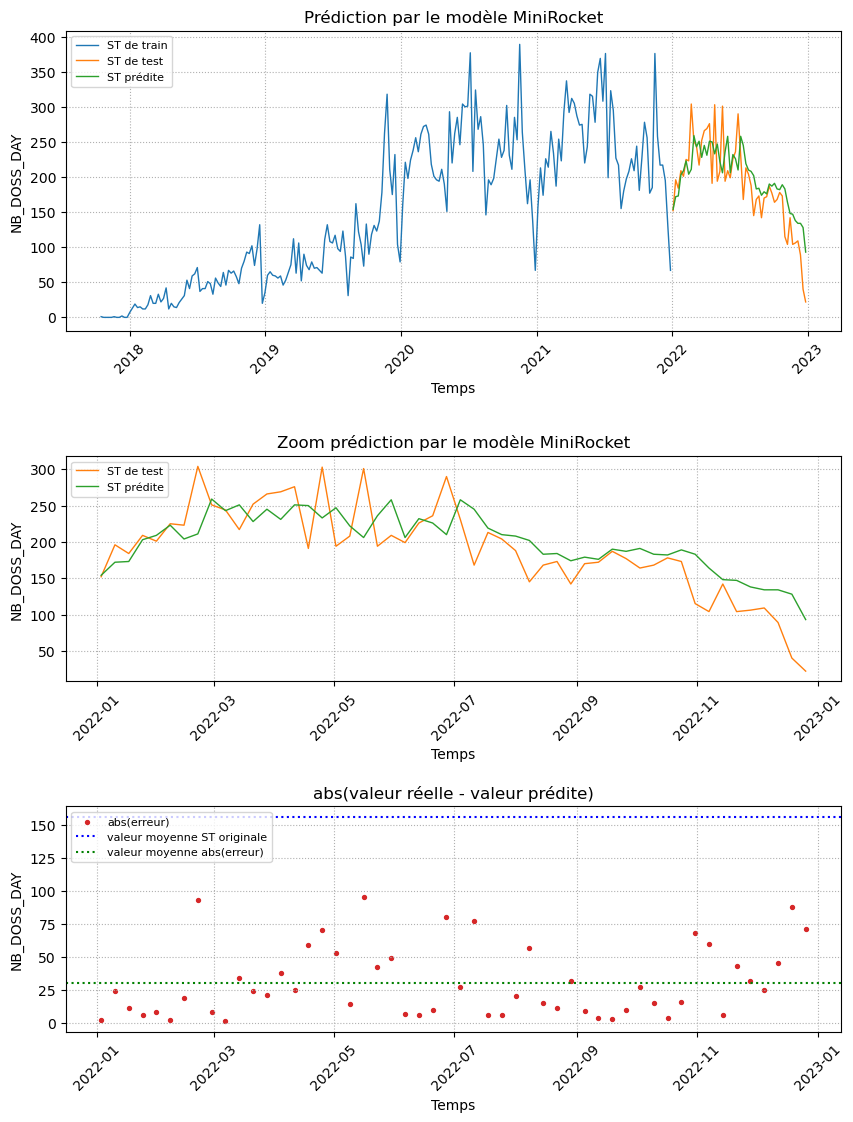

In [27]:
# Préparation de la Série temporelle pour affichage
# ----------------------------------------------
TS=TS_week.copy()
# ST prédite. Comme y_pred et TS[splits[1]] n'ont pas la même longueur à 
# cause des fenêtres glissantes, on effectue la manip ci-dessous
TS_forecast = TS*np.nan 
TS_forecast[-len(y_pred):] = y_pred

# Affichage de la Série temporelle
# ----------------------------------------------
dp1.plot_prediction(TS,TS_forecast,splits,conf_int=None,model_name='MiniRocket')

In [28]:
_ = dp1.compute_rmse(TS[splits[1]],TS_forecast[splits[1]])
_ = dp1.compute_mae(TS[splits[1]],TS_forecast[splits[1]])

rmse sur les données de test : 40.43799
mae sur les données de test : 30.34615


#### MiniRocket Signal Débruité

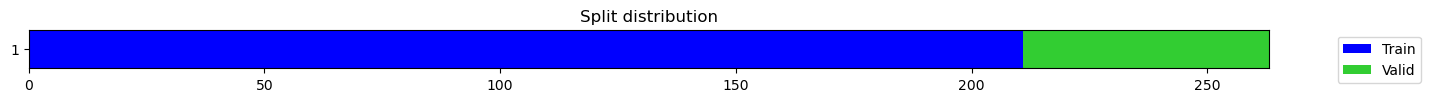

début de l'entraînement...
...fin !
rmse sur les données de test : 37.80507 temps d'exécution: 0.551726


In [29]:
# Entraînement signal débruité
# ----------------------------------------------
y_pred,rmse,splits = mr.run_miniRocket_uni(TSrec_week,window_length=9,n_estimators=5,valid_size=.2)

Valeur moyenne de la ST originale:  156
Valeur moyenne de l'erreur:  30


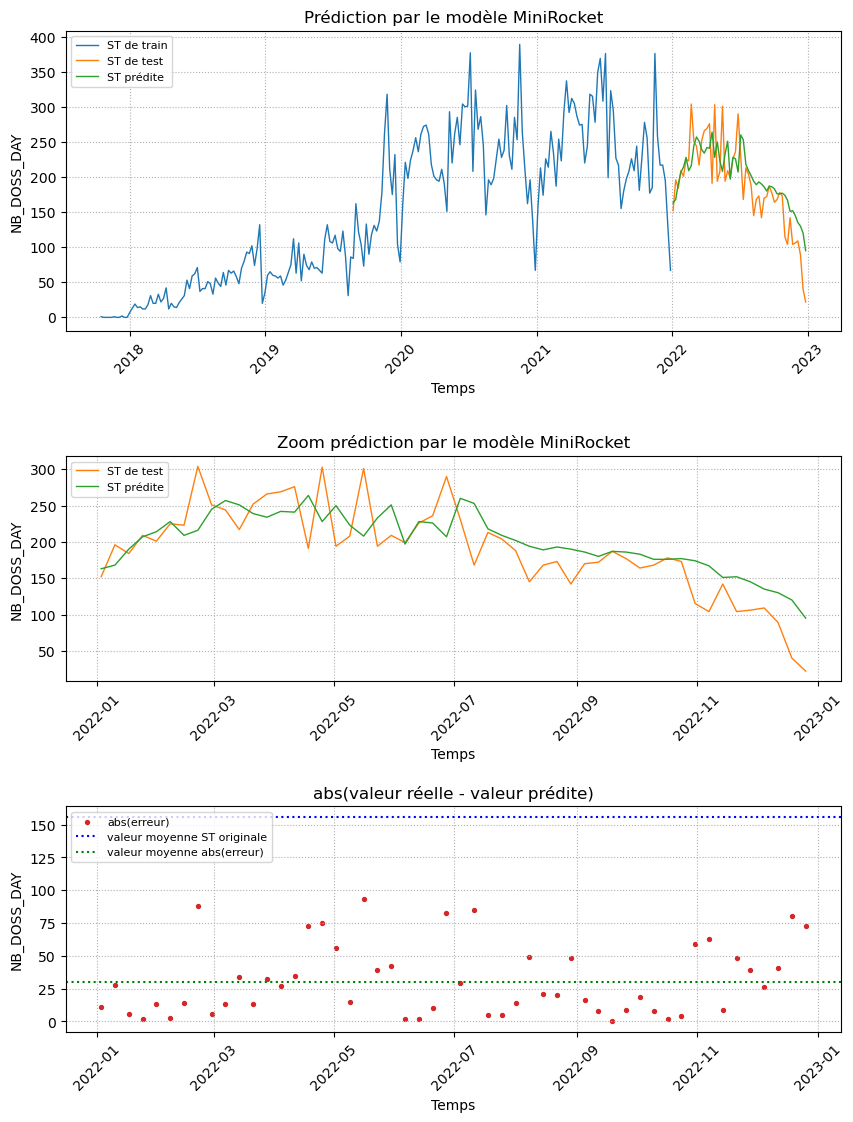

In [30]:
# Préparation de la Série temporelle pour affichage
# ----------------------------------------------
TS=TS_week.copy()
# ST prédite. Comme y_pred et TS[splits[1]] n'ont pas la même longueur à 
# cause des fenêtres glissantes, on effectue la manip ci-dessous
TS_forecast = TS*np.nan 
TS_forecast[-len(y_pred):] = y_pred

# Affichage de la Série temporelle
# ----------------------------------------------
dp1.plot_prediction(TS,TS_forecast,splits,conf_int=None,model_name='MiniRocket')

In [31]:
_ = dp1.compute_rmse(TS[splits[1]],TS_forecast[splits[1]])
_ = dp1.compute_mae(TS[splits[1]],TS_forecast[splits[1]])

rmse sur les données de test : 40.89456
mae sur les données de test : 30.67308


#### MiniRocket Signal Transformé Box-Cox

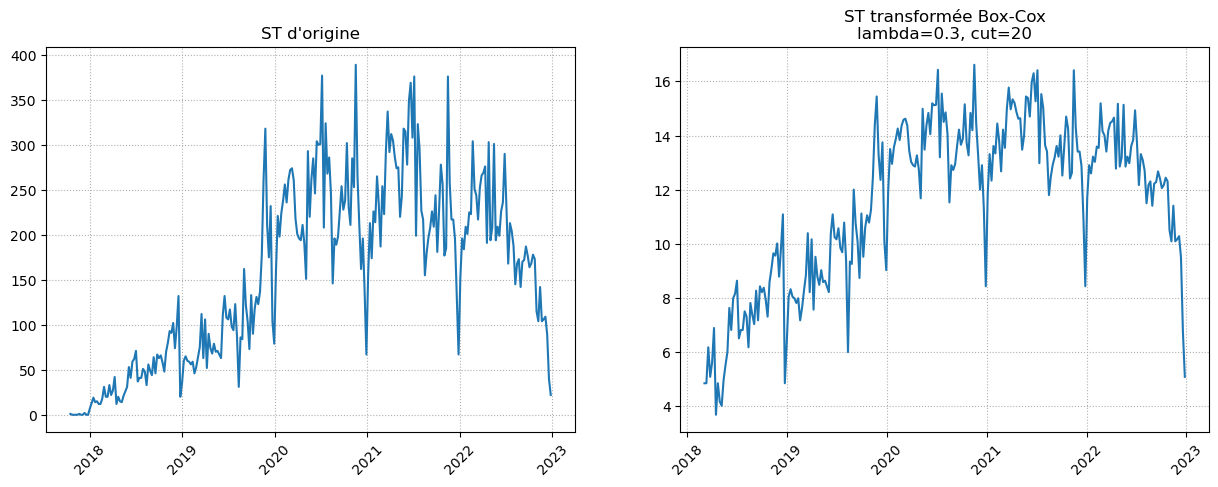

In [32]:
# Transformation du signal avec Box-Cox
# ----------------------------------------------
TS_trans,lam = dp1.transform_TS(TS_week,lam=.3)

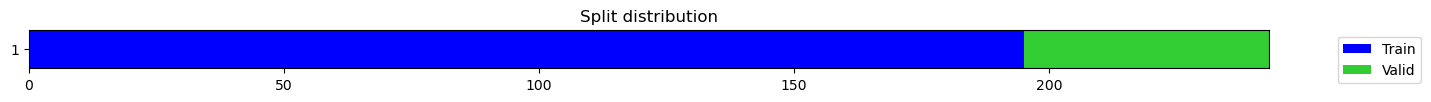

début de l'entraînement...
...fin !
rmse sur les données de test : 1.23692 temps d'exécution: 0.508624


In [33]:
# Entraînement signal transformé
# ----------------------------------------------
y_pred,rmse,splits = mr.run_miniRocket_uni(TS_trans,window_length=9,n_estimators=5,valid_size=.2)

Valeur moyenne de la ST originale:  168
Valeur moyenne de l'erreur:  32


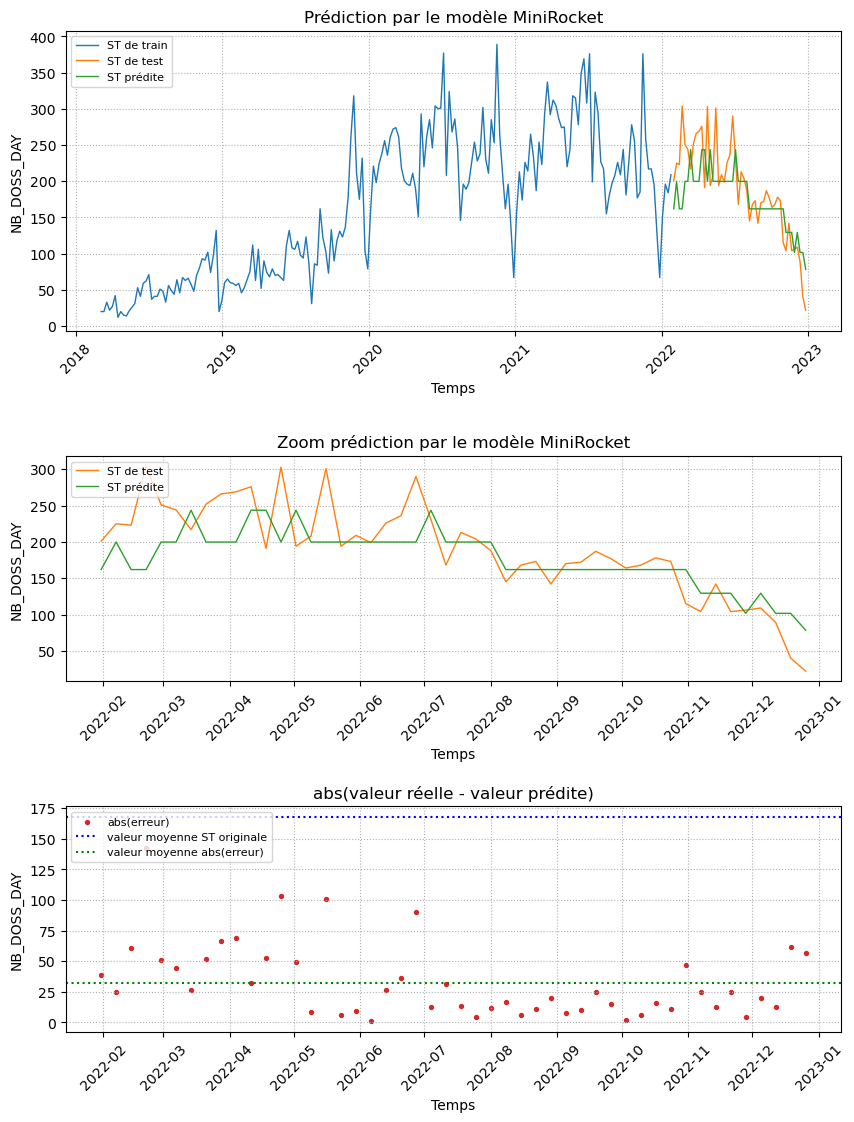

In [34]:
# Préparation de la Série temporelle pour affichage
# ----------------------------------------------
TS = TS_trans.copy()
TS =  dp1.transform_inv_TS(TS,lam)
# ST prédite. Comme y_pred et TS[splits[1]] n'ont pas la même longueur à 
# cause des fenêtres glissantes, on effectue la manip ci-dessous
TS_forecast = TS*np.nan 
TS_forecast[-len(y_pred):] = dp1.transform_inv_TS(y_pred,lam)

# Affichage de la Série temporelle
# ----------------------------------------------
dp1.plot_prediction(TS,TS_forecast,splits,conf_int=None,model_name='MiniRocket')

In [35]:
_ = dp1.compute_rmse(TS[splits[1]],TS_forecast[splits[1]])
_ = dp1.compute_mae(TS[splits[1]],TS_forecast[splits[1]])

rmse sur les données de test : 44.65676
mae sur les données de test : 32.90467


=> le débruitage et la transformation Box-Cox n'améliorent pas les résultats 